5.1

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

width = 9
height = 6
square_size = 0.025

objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp *= square_size

objpoints = []
imgpoints = []

img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = ""
image_dir = path + "pairs/"

number_of_images = 50

for i in range(1, number_of_images):
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    Y, X, channels = img.shape

    if (ret == True):
        minRx = corners[:, :, 0].min()
        maxRx = corners[:, :, 0].max()
        minRy = corners[:, :, 1].min()
        maxRy = corners[:, :, 1].max()

        border_threshold_x = X / 12
        border_threshold_y = Y / 12

        x_thresh_bad = False
        
        if (minRx < border_threshold_x):
            x_thresh_bad = True

        y_thresh_bad = False

        if (minRy < border_threshold_y):
            y_thresh_bad = True

        if (x_thresh_bad == True) or (y_thresh_bad == True):
            continue

    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

        imgpoints.append(corners2)

        cv2.drawChessboardCorners(img, (width, height), corners2, ret)
        cv2.imshow("Corners", img)
        if cv2.waitKey(100) == ord('q'):
            cv2.destroyAllWindows()
            break
    else:
        print("Chessboard couldn't detected. Image pair: ", i)
        continue

cv2.destroyAllWindows()

In [54]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

ret, K, D, _, _ = cv2.fisheye.calibrate(
    objpoints,
    imgpoints,
    image_size,
    K,
    D,
    rvecs,
    tvecs,
    calibration_flags,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)

print("\n--- Parametry Kamery po Kalibracji ---")
print(f"Status kalibracji (ret): {ret}")
print("Macierz kamery (K):")
print(K)
print("Współczynniki dystorsji (D):")
print(D.ravel())

map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)

undistorted_iamge = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
compare = np.hstack((img, undistorted_iamge))
cv2.imshow("Porownanie przed i po korekcji dystorsji", compare)
cv2.waitKey(0)
cv2.destroyAllWindows()

for i in range(1, number_of_images):
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    comparison_loop = np.hstack((img, undistorted_image))
    cv2.imshow(f'Oryginalny vs Skorygowany' , comparison_loop)

    if cv2.waitKey(100) == ord('q'):
       cv2.destroyAllWindows()
       break
cv2.destroyAllWindows()


--- Parametry Kamery po Kalibracji ---
Status kalibracji (ret): 0.10503771344758348
Macierz kamery (K):
[[337.88006935   0.         344.44454021]
 [  0.         337.64991389 233.80167287]
 [  0.           0.           1.        ]]
Współczynniki dystorsji (D):
[-0.02968358  0.0077064  -0.03617062  0.02825536]


5.2

In [55]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

width = 9
height = 6
square_size = 0.025

objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp *= square_size

objpoints = []
imgpoints_left = []
imgpoints_right = []

img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = ""
image_dir = path + "pairs/"

number_of_images = 50

for i in range(1, number_of_images):
    img_left = cv2.imread(image_dir + "left_%02d.png" % i)
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)

    img_right = cv2.imread(image_dir + "right_%02d.png" % i)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret_left and ret_right:
        objpoints.append(objp)
            
        corners2_left = cv2.cornerSubPix(gray_left, corners_left, (3, 3), (-1, -1), criteria)
        imgpoints_left.append(corners2_left)
        corners2_right = cv2.cornerSubPix(gray_right, corners_right, (3, 3), (-1, -1), criteria)
        imgpoints_right.append(corners2_right)


        cv2.drawChessboardCorners(img_left, (width, height), corners2_left, ret_left)
        cv2.drawChessboardCorners(img_right, (width, height), corners2_right, ret_right)

        cv2.imshow("Corners_left", img_left)
        cv2.imshow("Corners_right", img_right)
        
        if cv2.waitKey(100) == ord('q'):
            cv2.destroyAllWindows()
            break
cv2.destroyAllWindows()

N_OK = len(objpoints)

K_left = np.zeros((3, 3))
D_left = np.zeros((4, 1))
rvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

K_right = np.zeros((3, 3))
D_right = np.zeros((4, 1))
rvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

ret_left, K_left, D_left, _, _ = cv2.fisheye.calibrate(
    objpoints,
    imgpoints_left,
    image_size,
    K_left,
    D_left,
    rvecs_left,
    tvecs_left,
    calibration_flags,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)

ret_right, K_right, D_right, _, _ = cv2.fisheye.calibrate(
    objpoints,
    imgpoints_right,
    image_size,
    K_right,
    D_right,
    rvecs_right,
    tvecs_right,
    calibration_flags,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)

map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(K_left, D_left, np.eye(3), K, image_size, cv2.CV_16SC2)
map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(K_right, D_right, np.eye(3), K, image_size, cv2.CV_16SC2)

imgpoints_left = np.asarray(imgpoints_left, dtype = np.float64)
imgpoints_right = np.asarray(imgpoints_right, dtype = np.float64)
RMS, _, _, _, _, rotationMatrix, translationVector  = cv2.fisheye.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right,
    K_left, D_left,
    K_right, D_right,
    image_size, None, None,
    cv2.CALIB_FIX_INTRINSIC,
    criteria
    )
R2 = np.zeros ([3,3])
P1 = np.zeros ([3,4])
P2 = np.zeros ([3,4])
Q = np.zeros ([4,4])

leftRectification, rightRectification, leftProjection, rightProjection, dispartityToDepthMap = cv2.fisheye.stereoRectify(
    K_left, D_left,
    K_right, D_right,
    image_size,
    rotationMatrix, translationVector,
    0, R2, P1, P2, Q,
    cv2.CALIB_ZERO_DISPARITY, (0,0), 0, 0
    )

map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
    K_left, D_left, leftRectification,
    leftProjection, image_size, cv2.CV_16SC2
    )

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
    K_right, D_right, rightRectification,
    rightProjection, image_size, cv2.CV_16SC2
    )

img_left = cv2.imread(image_dir + "left_25.png")
img_right = cv2.imread(image_dir + "right_25.png")

dst_L = cv2.remap (img_left, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap (img_right, map1_right, map2_right, cv2.INTER_LINEAR)


N, XX, YY = dst_L.shape[:: -1]

visRectify = np.zeros((YY, XX *2, N), np.uint8)

visRectify [:, :XX, :] = dst_L
visRectify [:, XX: , :] = dst_R

for y in range (0, YY, 10):
    cv2.line (visRectify, (0, y), (XX * 2, y), (255,0,0))

cv2.imshow ('visRectify', visRectify)
cv2.waitKey(0)
cv2.destroyAllWindows()



5.3

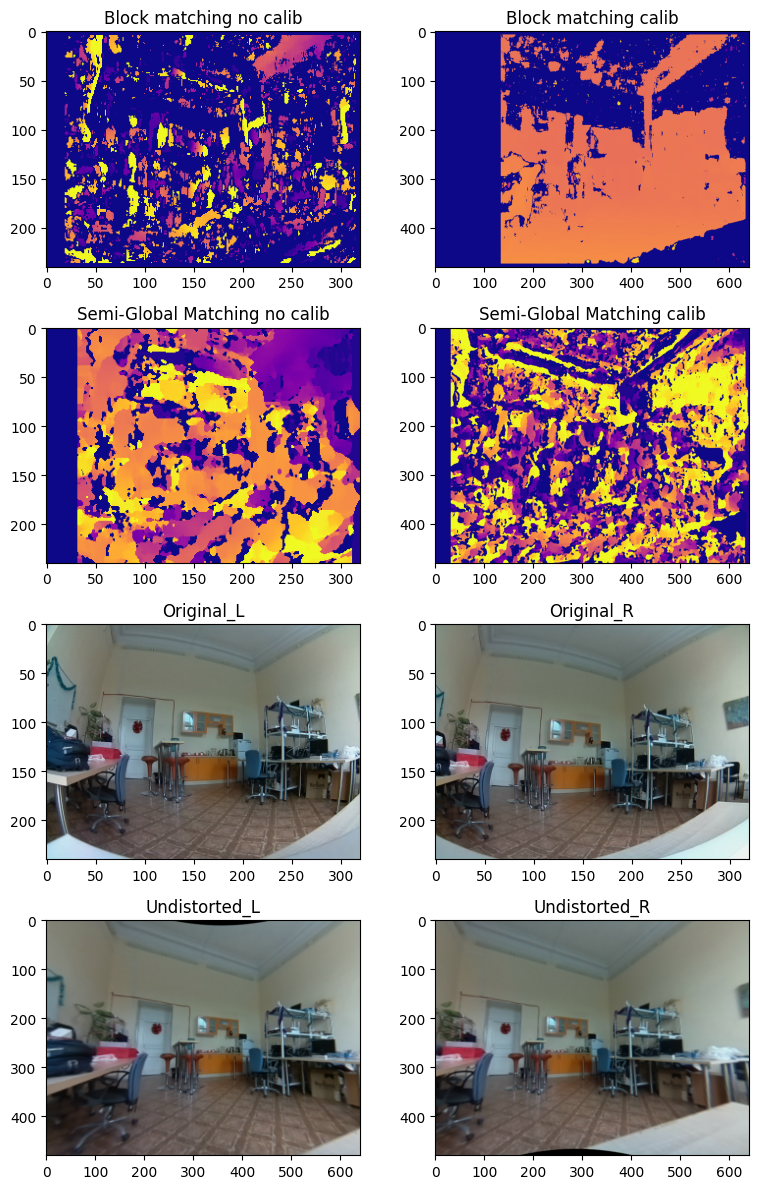

In [67]:
def compute_disparity(left_gray, right_gray, method='BM', num_disp=32, block_size=15):
    if method == 'BM':
        stereo = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
    else:
        stereo = cv2.StereoSGBM_create(numDisparities=num_disp, blockSize=block_size)
    return stereo.compute(left_gray, right_gray)

def process_and_visualize(image_path, map1_left, map2_left, map1_right, map2_right):
    num_parts = 2

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    rows = int(math.sqrt(num_parts))
    while num_parts % rows != 0:
        rows -= 1
    cols = num_parts // rows

    part_height = height // rows
    part_width = width // cols

    parts = [
        image[i * part_height:(i + 1) * part_height, j * part_width:(j + 1) * part_width]
        for i in range(rows)
        for j in range(cols)
    ]
    left_img, right_img = parts

    scale_factor = 2
    new_size = (left_img.shape[1] * scale_factor, left_img.shape[0] * scale_factor)

    left_scaled = cv2.resize(left_img, new_size, interpolation=cv2.INTER_LINEAR)
    right_scaled = cv2.resize(right_img, new_size, interpolation=cv2.INTER_LINEAR)

    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    left_remap = cv2.remap(left_scaled, map1_left, map2_left, interpolation=cv2.INTER_LINEAR)
    right_remap = cv2.remap(right_scaled, map1_right, map2_right, interpolation=cv2.INTER_LINEAR)

    left_remap_gray = cv2.cvtColor(left_remap, cv2.COLOR_BGR2GRAY)
    right_remap_gray = cv2.cvtColor(right_remap, cv2.COLOR_BGR2GRAY)

    disparities = {
        "BM_Original": compute_disparity(left_gray, right_gray, 'BM', num_disp=16, block_size=9),
        "SGBM_Original": compute_disparity(left_gray, right_gray, 'SGBM'),
        "BM_Undistorted": compute_disparity(left_remap_gray, right_remap_gray, 'BM', num_disp=128, block_size=15),
        "SGBM_Undistorted": compute_disparity(left_remap_gray, right_remap_gray, 'SGBM'),
    }

    disparities_color = {
        key: cv2.applyColorMap(
            cv2.normalize(val, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U),
            cv2.COLORMAP_PLASMA
        )
        for key, val in disparities.items()
    }

    images_to_plot = [
        ("Block matching no calib", disparities_color["BM_Original"]),
        ("Block matching calib", disparities_color["BM_Undistorted"]),
        ("Semi-Global Matching no calib", disparities_color["SGBM_Original"]),
        ("Semi-Global Matching calib", disparities_color["SGBM_Undistorted"]),
        ("Original_L", left_img),
        ("Original_R", right_img),
        ("Undistorted_L", left_remap),
        ("Undistorted_R", right_remap)
    ]

    fig, axs = plt.subplots(4, 2, figsize=(8, 12))
    for ax, (title, img) in zip(axs.flat, images_to_plot):
        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

image_path = './example/example1.png'

process_and_visualize(image_path, map1_left, map2_left, map1_right, map2_right)